In [21]:
import numpy as np
import h5py as h5
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# from matplotlib.patches import Polygon
# from matplotlib.collections import PatchCollection
from datetime import datetime, timedelta
import pandas as pd
from shapely.geometry.polygon import Polygon
from natsort import natsorted, ns, natsort_keygen
import re

In [2]:
def batch_delta_to_time(origin, x, time_format, delta_format):
    y = []
    for ix in x:
        if delta_format == "hours":
            temp_y = origin + timedelta(hours=ix)
        elif delta_format == "days":
            temp_y = origin + timedelta(days=ix)
        elif delta_format == "minutes":
            temp_y = origin + timedelta(minutes=ix)
        elif delta_format == "weeks":
            temp_y = origin + timedelta(weeks=ix)
        elif delta_format == "seconds":
            temp_y = origin + timedelta(seconds=ix)
        elif delta_format == "microseconds":
            temp_y = origin + timedelta(microseconds=ix)
        elif delta_format == "milliseconds":
            temp_y = origin + timedelta(milliseconds=ix)
        else:
            print("Sorry, this naive program only solve single time unit")
        y.append(temp_y.strftime(time_format))
    y = np.asarray(y)
    return(y)

In [23]:
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)  

# I/O files

In [3]:
#input
case_name = "HFR_model_100x100x2_cyclic/"

model_dir = "/global/cscratch1/sd/pshuai/" + case_name
# fname_model_origin = model_dir + "model_origin.txt"
fname_material_h5 = model_dir + "HFR_material_river.h5"
fname_pflotran_h5 = model_dir + "pflotran_100x100x2_cyclic.h5"

data_dir = "/global/project/projectdirs/m1800/pin/Reach_scale_model/data/"
fname_mass1_coord = data_dir + "MASS1/coordinates.csv"

#output
out_dir = "/global/project/projectdirs/m1800/pin/Reach_scale_model/Outputs/" + case_name
# fig_wl = out_dir + 'wl/'
fig_tracer = out_dir + "tracer/"

data_dir = "/global/project/projectdirs/m1800/pin/Reach_scale_model/data/"
fname_river_geo = data_dir + "river_geometry_manual.csv"
# output_dir = "/Users/song884/remote/reach/Outputs/HFR_100x100x5_6h_bc/"
# fig_dir = "/Users/song884/remote/reach/figures/HFR_100x100x5_6h_bc/wl/"
# data_dir = "/Users/song884/remote/reach/data/"

In [4]:
date_origin = datetime.strptime("2007-03-28 12:00:00", "%Y-%m-%d %H:%M:%S")
# model_origin = np.genfromtxt(
#     fname_model_origin, delimiter=" ", skip_header=1)
model_origin = [551600, 104500]

## import mass1 coord

In [5]:
## read mass1 coordinates
section_coord = np.genfromtxt(
    fname_mass1_coord, delimiter=",", skip_header=1)
section_coord[:, 1] = section_coord[:, 1] - model_origin[0]
section_coord[:, 2] = section_coord[:, 2] - model_origin[1]
line1 = section_coord[0, 1:3] / 1000
line2 = section_coord[int(len(section_coord[:, 1]) / 2), 1:3] / 1000
line3 = section_coord[-1, 1:3] / 1000

line1_x = [line1[0]] * 2
line1_y = [line1[1] - 5, line1[1] + 5]
line2_x = [line2[0] - 5, line2[0] + 5]
line2_y = [line2[1]] * 2
line3_x = [line3[0] - 5, line3[0] + 5]
line3_y = [line3[1]] * 2

## import model dimension

In [6]:
# all_h5 = glob.glob(fname_pflotran_h5) # find all "pflotran*.h5" files
# all_h5 = np.sort(all_h5)

input_h5 = h5.File(fname_pflotran_h5, "r")
groups = list(input_h5.keys()) # create a list with group names
time_index = [s for s, s in enumerate(groups) if "Time:" in s] # enumerate returns its index (index, string)

In [30]:
# sort time based on scientific value
time_index = sorted(time_index, key = lambda time: float(time[7:18]))

In [31]:
real_itime = [str(batch_delta_to_time(date_origin, [float(itime[7:18])], "%Y-%m-%d %H:%M:%S", "hours")[0])
              for itime in time_index]

In [35]:
x_grids = list(input_h5["Coordinates"]['X [m]'])
y_grids = list(input_h5["Coordinates"]['Y [m]'])
z_grids = list(input_h5["Coordinates"]['Z [m]'])


dx = np.diff(x_grids)
dy = np.diff(y_grids)
dz = np.diff(z_grids)

nx = len(dx)
ny = len(dy)
nz = len(dz)

# x,y,z coordinates at cell center
x = x_grids[0] + np.cumsum(dx) - 0.5 * dx[0]
y = y_grids[0] + np.cumsum(dy) - 0.5 * dy[0]
z = z_grids[0] + np.cumsum(dz) - 0.5 * dz[0]

# create grids--a list of arrays based nx, ny, nz
grids = np.asarray([(x, y, z) for z in range(nz)
                    for y in range(ny) for x in range(nx)])

## import river cells

In [11]:
# open file for reading
material_h5 = h5.File(fname_material_h5, "r") 

# read river cell ids
river_cells = []
for i_region in list(material_h5['Regions'].keys()):
    river_cells = np.append(river_cells, np.asarray(
        list(material_h5["Regions"][i_region]["Cell Ids"])))
river_cells = np.unique(river_cells).astype(int)
river_cells = river_cells - 1  # need minus 1 as python index started with 0
# label river cells in x-y plane with '1'
yx_river = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx) # initialize ny*nx array with nan value
for icell in river_cells:
    yx_river[grids[icell, 1], grids[icell, 0]] = 1
    
material_h5.close()

## import river geometry

In [36]:
river_geo = pd.read_csv(fname_river_geo)

river_geo['x'] = (river_geo['x'] - model_origin[0])/1000
river_geo['y'] = (river_geo['y'] - model_origin[1])/1000

polygon = Polygon(river_geo.loc[:, ["x", "y"]].values)
river_x,river_y = polygon.exterior.xy

# plot tracer contour

2010-11-13 12:00:00


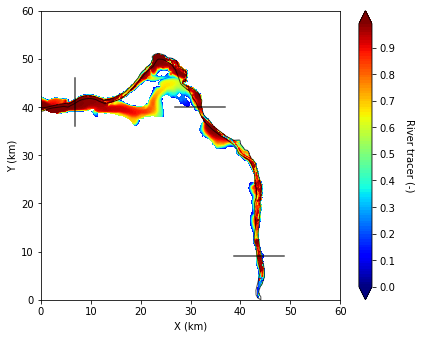

In [41]:
%matplotlib inline
# patches = []
# loop over time step
for itime in time_index[-1::20]:

#     print(itime)
    # initialize total head
    temp_max_tracer = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx)
    # read pressure
    temp_total_tracer = np.asarray(list(input_h5[itime]["Total_Tracer [M]"]))

    for ix in range(nx):
        for iy in range(ny):
                max_index = np.argmax(temp_total_tracer[ix, iy, :])
                temp_max_tracer[iy, ix] = temp_total_tracer[ix, iy, max_index] # for contour plot, temp_max_tracer must has shape of (ny, nx)
    
    temp_max_tracer[temp_max_tracer < 0.1] = np.nan
    
    real_itime = batch_delta_to_time(date_origin, [float(
        itime[7:18])], "%Y-%m-%d %H:%M:%S", "hours")
    real_itime = str(real_itime[0])
    
    print(real_itime)
    ## plot tracer contour

    gs = gridspec.GridSpec(1, 1)
    fig = plt.figure()
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(line1_x, line1_y, "black", alpha =0.7)
    ax1.plot(line2_x, line2_y, "black", alpha =0.7)
    ax1.plot(line3_x, line3_y, "black", alpha =0.7)
    
#     ax1.plot(river_x, river_y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    
    cf1 = ax1.contourf(x / 1000, y / 1000, temp_max_tracer,
                       cmap=plt.cm.jet,
                       levels=np.arange(0, 1, 0.01),
                       vmin=0,
                       vmax=1,
                       extend="both",
#                        V=np.arange(0, 1, 0.1)
                       )
#     cf2 = ax1.contour(x / 1000, y / 1000, temp_max_tracer,
#                       colors="grey",
#                       levels=[0.5],
#                       linewidths=1,
#                       vmin=0,
#                       vmax=1)
#     plt.clabel(cf2, inline = True, fmt = '%3.0d', fontsize = 10)

    # plot river shape
    ax1.plot(river_x, river_y, color='black', alpha=0.7, linewidth=1, solid_capstyle='round', zorder=2)
 
    ax1.set_xlabel("X (km)")
    ax1.set_ylabel("Y (km)")

    ax1.set_xlim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])
    ax1.set_ylim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])
#     ax1.set_aspect("equal", "datalim")
    cb1 = plt.colorbar(cf1, spacing = "uniform", ticks=np.arange(0, 1.1, 0.1))  # ,
    #                           orientation="horizontal", shrink=0.8, aspect=25)
    cb1.ax.set_ylabel("River tracer (-)", rotation=270, labelpad=20)
    
   
    fig.tight_layout()
#     cf3 = ax1.contourf(x / 1000, y / 1000, yx_river, colors="black")
    fig.set_size_inches(6, 5)

In [11]:
    fig_name = fig_tracer + real_itime + ".jpg"
    fig.savefig(fig_name, dpi=300, transparent=False)
    plt.close(fig)
    

2007-03-28 12:00:00
2007-03-29 00:00:00
2007-03-29 06:00:00


In [12]:
input_h5.close()